In [1]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects


2023-06-15 16:25:15.483883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jcampos/miniforge3/lib/:/home/jcampos/miniforge3/lib/
2023-06-15 16:25:15.483907: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
import sys
sys.path.append("..")
import os 
import hls4ml
import numpy as np
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt

In [5]:
from utils.config import print_dict

In [6]:
data_dir = '../data/qick/'

X_train_val = np.load(os.path.join(data_dir, 'X_train.npy'))
X_test = np.ascontiguousarray(np.load(os.path.join(data_dir, 'X_test.npy')))
y_train_val = np.load(os.path.join(data_dir, 'y_train.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy'), allow_pickle=True)

print(f'X_train max {X_train_val.max()}')
print(f'X_train min {X_train_val.min()}')

print(f'X_test max {X_test.max()}')
print(f'X_test min {X_test.min()}')

X_train max 6453.0
X_train min -6643.0
X_test max 6195.0
X_test min -6463.0


In [7]:
co = {} 
_add_supported_quantized_objects(co)
model = load_model('qkeras_best_bs12800_e250_val0.1_lr0.01.h5', custom_objects=co, compile=False)

y_pred = model.predict(X_test)
keras_acc = accuracy_score(y_test, np.argmax(y_pred, axis=1)) 

print(model.summary()) 
print(f'QKeras Accuracy: {keras_acc}')

2023-06-15 16:26:31.026982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/jcampos/miniforge3/lib/:/home/jcampos/miniforge3/lib/
2023-06-15 16:26:31.027033: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-15 16:26:31.027075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator3.fnal.gov): /proc/driver/nvidia/version does not exist
2023-06-15 16:26:31.027506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


63/63 [==============================] - 0s 3ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 192)               295872    
                                                                 
 relu1 (QActivation)         (None, 192)               0         
                                                                 
 batch_normalization (BatchN  (None, 192)              768       
 ormalization)                                                   
                                                                 
 fc2 (QDense)                (None, 2)                 386       
                                                                 
 relu2 (QActivation)         (None, 2)                 0         
                                                                 
Total params: 297,026
Trainable params: 296,642
Non-trainable params:

In [8]:
## Save inputs and ground truth for HLS testbench 
np.savetxt('tb_input_features.dat', X_test, fmt='%i')
np.savetxt('tb_output_predictions.dat', y_pred, fmt='%.3f')

In [9]:
OutputDir = 'hls4ml_prj_qkeras/'
XilinxPart = 'xczu49dr-ffvf1760-2-e'
IOType = 'io_parallel'
ClockPeriod = 5
HLSFig = OutputDir+'model.png'

HLSConfig = {}
HLSConfig['LayerName'] = {}

for layer in ['fc1_input', 'fc1', 'fc1_linear', 'relu1', 'batch_normalization', 'fc2', 'fc2_linear', 'relu2']:
    HLSConfig['LayerName'][layer] = {}
    HLSConfig['LayerName'][layer]['Trace'] = True

HLSConfig['LayerName']['fc1_input']['Precision'] = 'ap_fixed<14,14>'
HLSConfig['LayerName']['fc1']['Precision'] = 'ap_fixed<20,17>'
HLSConfig['LayerName']['fc1_linear']['Precision'] = 'ap_fixed<20,17>'

HLSConfig['LayerName']['fc2']['Precision'] = 'ap_fixed<12,7>'
HLSConfig['LayerName']['fc2_linear']['Precision'] = 'ap_fixed<12,7>'

HLSConfig['LayerName']['batch_normalization']['Precision'] = 'ap_fixed<10,3>'

HLSConfig['LayerName']['relu1']['Precision'] = 'ap_ufixed<6,3,AP_RND,AP_SAT>'
HLSConfig['LayerName']['relu2']['Precision'] = 'ap_ufixed<6,3,AP_RND,AP_SAT>'

print_dict(HLSConfig)

LayerName
  fc1_input
    Trace:           True
    Precision:       ap_fixed<14,14>
  fc1
    Trace:           True
    Precision:       ap_fixed<20,17>
  fc1_linear
    Trace:           True
    Precision:       ap_fixed<20,17>
  relu1
    Trace:           True
    Precision:       ap_ufixed<6,3,AP_RND,AP_SAT>
  batch_normalization
    Trace:           True
    Precision:       ap_fixed<10,3>
  fc2
    Trace:           True
    Precision:       ap_fixed<12,7>
  fc2_linear
    Trace:           True
    Precision:       ap_fixed<12,7>
  relu2
    Trace:           True
    Precision:       ap_ufixed<6,3,AP_RND,AP_SAT>


In [10]:
hls_model = hls4ml.converters.convert_from_keras_model(
    model=model,
    hls_config=HLSConfig,
    output_dir=OutputDir,
    part=XilinxPart,
    io_type=IOType,
    clock_period=ClockPeriod,
)


Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 1540]], output shape: [None, 1540]
Layer name: fc1, layer type: QDense, input shapes: [[None, 1540]], output shape: [None, 192]
Layer name: relu1, layer type: Activation, input shapes: [[None, 192]], output shape: [None, 192]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 192]], output shape: [None, 192]
Layer name: fc2, layer type: QDense, input shapes: [[None, 192]], output shape: [None, 2]
Layer name: relu2, layer type: Activation, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model


In [11]:
print(f"Creating hls4ml project directory {OutputDir}")
hls_model.compile()

# visualize model, save img in OutputDir
hls4ml.utils.plot_model(
    hls_model, show_shapes=True, show_precision=True, to_file=HLSFig
)

Creating hls4ml project directory hls4ml_prj_qkeras/
Writing HLS project


Done


In [12]:
# Compute HLS model accuracy/fidelity 
y_hls = hls_model.predict(np.ascontiguousarray(X_test.astype(np.float32))) 
hls_acc = accuracy_score(y_test, np.argmax(y_hls, axis=1)) 
print(f'HLS Model accuracy: {hls_acc}')

HLS Model accuracy: 0.9505


In [13]:
# Get HLS and Qkeras traces
_, hls_trace = hls_model.trace(np.ascontiguousarray(X_test.astype(np.float32)))
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test) 

Recompiling myproject with tracing
Writing HLS project


Done
Processing fc1 in Keras model...
63/63 [==============================] - 0s 2ms/step
Processing relu1 in Keras model...
63/63 [==============================] - 0s 2ms/step
Processing batch_normalization in Keras model...
63/63 [==============================] - 0s 2ms/step
Processing fc2 in Keras model...
63/63 [==============================] - 0s 2ms/step
Processing relu2 in Keras model...
63/63 [==============================] - 0s 3ms/step
Done taking outputs for Keras model.


fc1 		 0.0
hls/keras min: -48503.75/-48503.75
hls/keras max: 49476.375/49476.375


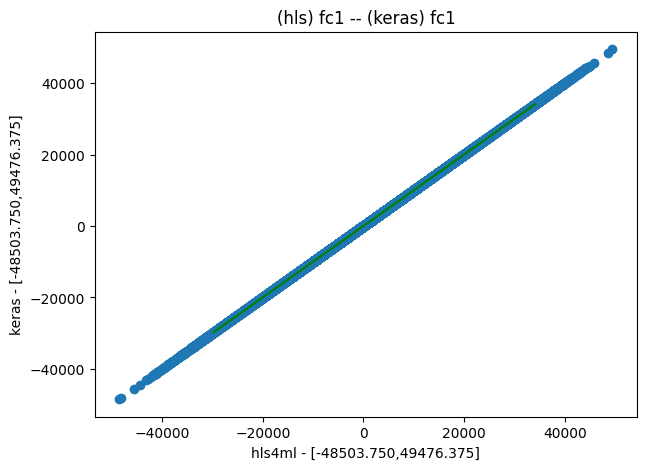

relu1 		 0.0
hls/keras min: 0.0/0.0
hls/keras max: 7.875/7.875


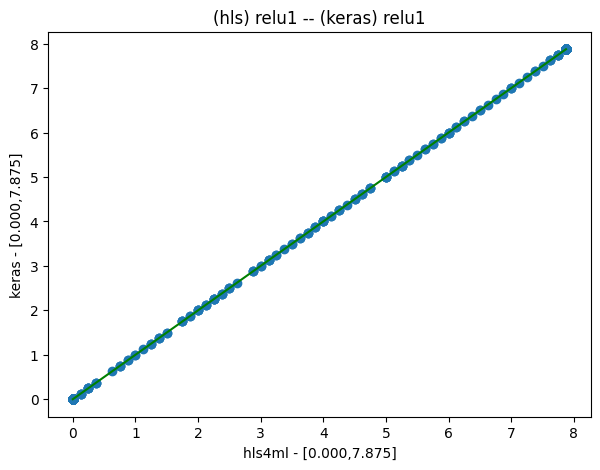

batch_normalization 		 0.020706514
hls/keras min: -2.3671875/-2.3612797260284424
hls/keras max: 2.5/2.528005361557007


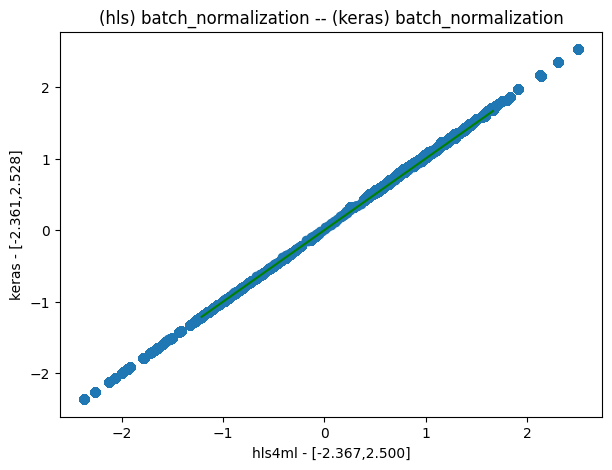

fc2 		 1.0319492
hls/keras min: -47.34375/-46.71479797363281
hls/keras max: 17.65625/19.486549377441406


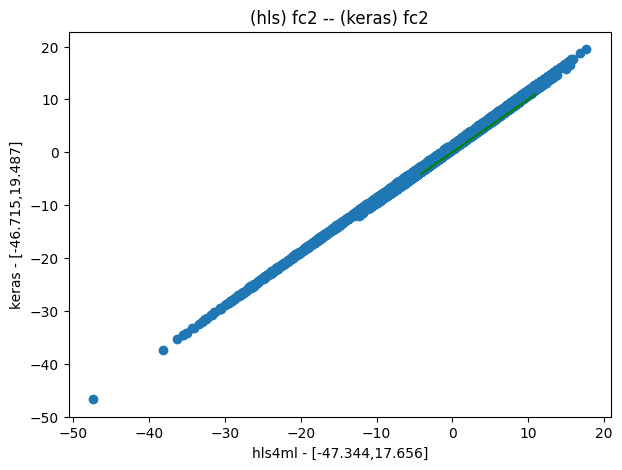

relu2 		 0.25465626
hls/keras min: 0.0/0.0
hls/keras max: 7.875/7.875


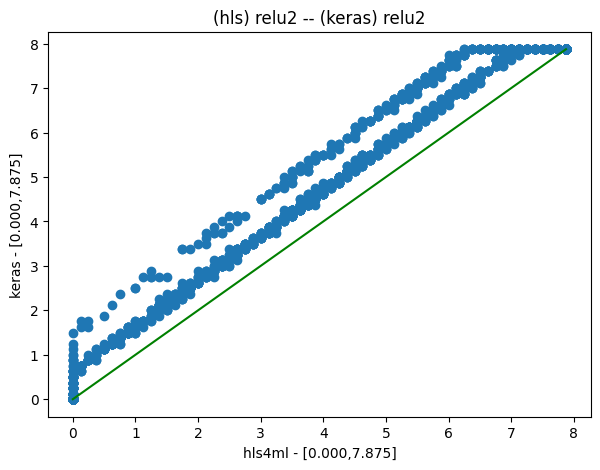

In [14]:
layers = ['fc1', 'relu1', 'batch_normalization', 'fc2', 'relu2']

for idx, layer in enumerate(layers):
    keras_layer, hls_layer = keras_trace[layer], hls_trace[layer]
    try:
        diff = np.average(np.abs(keras_layer - hls_layer ))
        print(f'{layer}', '\t\t', diff)
        
        plt.figure(figsize=(7, 5))

        plt.scatter(hls_layer.flatten(), keras_layer.flatten())
        min_x = min(keras_layer[0].min(), hls_layer[0].min())
        max_x = min(keras_layer[0].max(), hls_layer[0].max())

        onnx_min, onnx_max = keras_layer.flatten().min(), keras_layer.flatten().max()
        hls_min, hls_max = hls_layer.flatten().min(), hls_layer.flatten().max()
        
        print(f'hls/keras min: {hls_min}/{onnx_min}')
        print(f'hls/keras max: {hls_max}/{onnx_max}')
        
        plt.plot([min_x, max_x], [min_x, max_x], c='green')

        plt.title(f'(hls) {layer} -- (keras) {layer}')
        plt.xlabel(f'hls4ml - [{hls_min:.3f},{hls_max:.3f}]')
        plt.ylabel(f'keras - [{onnx_min:.3f},{onnx_max:.3f}]')
        plt.show()
        
        plt.savefig(f'../results/{idx}_(hls){layer} -- (keras){layer}.png')
        plt.close()

    except Exception as e:
        print(e)
